<a href="https://colab.research.google.com/github/MarinaOhm/marina/blob/main/Fake_News_Detector_using_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Fake news detector using Bi-LSTM

In [ ]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
fake=pd.read_csv('Fake.csv', engine='python', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
true=pd.read_csv('True.csv', engine='python', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploring the raw datasets

In [ ]:
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [ ]:
print('The dataset for fake news consists of ' + str(fake.shape[0]) + ' rows, and ' + str(fake.shape[1]) + ' columns')
print('The dataset for true news consists of ' + str(true.shape[0]) + ' rows, and ' + str(true.shape[1]) + ' columns')
print('\n')
print('The columns that the dataset for fake news contain is: ' + str(fake.columns))
print('The columns that the dataset for true news contain is: ' + str(true.columns))
print('\n')
print('The subjects that the fake news dataset holds are: \n' + str(fake['subject'].value_counts()))
print('\n')
print('The subjects that the true news dataset holds are: \n' + str(true['subject'].value_counts()))

The dataset for fake news consists of 7715 rows, and 4 columns
The dataset for true news consists of 8278 rows, and 4 columns


The columns that the dataset for fake news contain is: Index(['title', 'text', 'subject', 'date'], dtype='object')
The columns that the dataset for true news contain is: Index(['title', 'text', 'subject', 'date'], dtype='object')


The subjects that the fake news dataset holds are: 
News    7715
Name: subject, dtype: int64


The subjects that the true news dataset holds are: 
politicsNews    8278
Name: subject, dtype: int64


Another great way of getting a grasp on text data is through wordclouds, thus we will create a wordcloud for each of the datasets




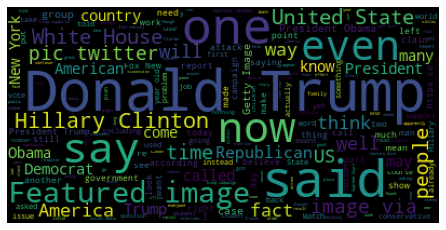

In [ ]:
wordcloud_fake=WordCloud().generate(' '.join(fake['text'].tolist()))
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

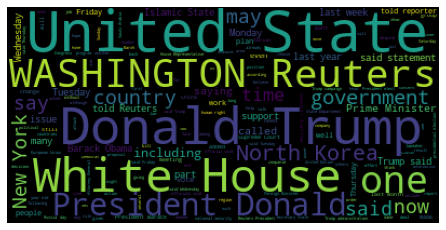

In [ ]:
wordcloud_true=WordCloud().generate(' '.join(true['text'].tolist()))
plt.imshow(wordcloud_true)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# The words that appear most frequently is the ones that are highlighted as bigger in the wordclouds
# This means that for fake news words as Donald Trump, Said, Hillary Clinton, and United states apperar frequently in the fake news
# And for the true news dataset, words as White House, WASHINGTON, Reuters, and United state appears frequently

In [ ]:
# Before cleaning and preprocessing the data we will first add a class column to each of them which is to indicate
# whether a given news text is FAKE or TRUE. Following whis we will append the datasets to each other

In [ ]:
# Fake news will have a class 0, and true news will have a class 1
fake['class']=0 
true['class']=1

In [ ]:
# For our model we only need (1) the text, and (2) which class it belongs to
df=fake[['text', 'class']].append(true[['text', 'class']], ignore_index=True)

In [ ]:
# Next, we want create a function that can remove punctuations, special characters, stopwords and lower the text

def preprocess(text):
  stop_words=stopwords.words('english')

  # Lower the text
  text = text.lower()

  # Remove punctuations
  text = re.sub(r'[^\w ]+', "", text)
  text = ' '.join(text.split())

  #Remove stopwords, words in less than 2 characters, and digits
  text = ' '.join([word for word in text.split() if word not in stop_words])

  text = ' '.join([word for word in text.split() if len(word)>2])

  text = ' '.join([word for word in text.split() if not word.isdigit()])

  return text

In [ ]:
# Applying the preprocess function to the text column

df['text']=df['text'].apply(lambda x: preprocess(x))

In [ ]:
df.head(5)

,text,class
0,donald trump wish americans happy new year lea...,0
1,house intelligence committee chairman devin nu...,0
2,friday revealed former milwaukee sheriff david...,0
3,christmas day donald trump announced would bac...,0
4,pope francis used annual christmas day message...,0


In [ ]:
# We will now continue with data preprocessing

# First we will subset the class in a seperate variable y, and store the text column in the variable X

y=df['class'].values
X=df['text']


In [ ]:
# Tokenizing the text data, the input is text data - the output is sets of sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
# After tokenizing the data we will encode the sequences meaning that the text sentenes is
# converted into a sequence of numbers where each number is matched up to the index of the corresponding word

X = tokenizer.texts_to_sequences(X)

In [ ]:
# We need the maximum sequence length in order to pad our encoded sequences

max_sequence_len = max([len(x) for x in X])


In [ ]:
# We now want to pad all the sequences so that they are of the same length. 
X = pad_sequences(X, maxlen=max_sequence_len)

In [ ]:
# As seen below, X is now a 2D numpy array, where all sequences are of the same length
X


array([[    0,     0,     0, ...,  1702, 24335,   356],
       [    0,     0,     0, ...,   261,  6334,   356],
       [    0,     0,     0, ...,  3974,  8644,   356],
       ...,
       [    0,     0,     0, ...,   567,  4011,     1],
       [    0,     0,     0, ...,   354,   509,  6620],
       [    0,     0,     0, ...,  5455,   201,   330]], dtype=int32)

In [ ]:
# Getting the length of the vocabulary
vocab_length = len(tokenizer.word_index) + 1

In [ ]:
# Splitting data into trainingset and test set before building the model
# We will use 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
  # Next, we will build the Bi-directional LSTM model

model = Sequential()

# The embedding layer is constituting of an input dimension which is the size of the vocabulary
# an output dimension which is set as 100 and indicates the size of the output vectors
# and an input length argument which is the length of the input sequences.
# Because of the previous padding all sequences are of the same length.
model.add(Embedding(vocab_length, 100, input_length=max_sequence_len))

# Adding a birectional layer to the model with 64 units 
model.add(Bidirectional(LSTM(64)))

# Setting sigmoid and relu as activation functions
model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

# And 'adam' as optimizer, 'binary_crossentropy' as loss function, and the accuracy metric for performance measurement
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

# Training the model on the training sets with a batch size of 64, and 2 epochs
# Furthermore we use 25% of the data for validation
print('Training model...')
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=2, 
          validation_split=0.25)

Training model...
Epoch 1/2
395/395 [==============================] - 4429s 11s/step - loss: 0.1649 - accuracy: 0.9377 - val_loss: 0.0752 - val_accuracy: 0.9865
Epoch 2/2
395/395 [==============================] - 4491s 11s/step - loss: 0.0251 - accuracy: 0.9950 - val_loss: 0.0165 - val_accuracy: 0.9964


In [ ]:
# From the above we find that the training accuracy is 0.9950, and the validation accuracy is 0.9964

In [ ]:
# We now want to check the accuracy on the test accuracy

# The model.predict() function will give a probability, therefore we added >= so that if the 
# probability is greater than 0.5, a one will be assigned (true news), and if not, a 0 indicating fake news
y_pred=(model.predict(X_test) >= 0.5).astype(int)

In [ ]:
# The accuracy score compares the y_test which is the true value, with the y_pred which is the predicted value
accuracy_score(y_test, y_pred)

# Output: 0.9964365256124722

0.9964365256124722

In [ ]:
# To get a more advanced assessment of the model we use the classification_report function
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5888
           1       0.99      1.00      1.00      5337

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

